MIDA Gondara and Wang(2018) in Python (using PyTorch)
https://arxiv.org/abs/1705.02737
https://gist.github.com/lgondara/18387c5f4d745673e9ca8e23f3d7ebd3 

# 1. Loading Dataset

## 1.1. Load a dataset and introduce missingness

Dataset used: Shuttle Dataset (https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)

### 1.1.1. Load the dataset and store it as dataframe(numeric)

In [45]:
import pandas as pd
import utils

In [46]:
#Test
filename = "data/satellite/sat_trn"
df = utils.get_dataframe_from_csv(filename).iloc[:,:-1]  #remove label

INFO:root:Input filename has to be space separated data


In [47]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,92,115,120,94,84,102,106,79,84,102,...,134,104,88,121,128,100,84,107,113,87
1,84,102,106,79,84,102,102,83,80,102,...,128,100,84,107,113,87,84,99,104,79
2,84,102,102,83,80,102,102,79,84,94,...,113,87,84,99,104,79,84,99,104,79
3,80,102,102,79,84,94,102,79,80,94,...,104,79,84,99,104,79,84,103,104,79
4,84,94,102,79,80,94,98,76,80,102,...,104,79,84,103,104,79,79,107,109,87


### 1.1.2. Inducing missingness

After dataset loading, start with inducing missingness. 

To start off, introduce simple random missing patterns (Missing Completely At Random), i.e. sample half of the variables and set observations in those variables to missing if an appended random uniform vector has value less than a certain threshhold. WIth threshold of 0.2, the procedure should introduce about 20% missingness.

In [48]:
#test
df1 = df[:]
df2 = utils.induce_missingness(df1,logger_level=20)

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 9.81


In [49]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,92,115,120,94,84,102,106,79,84,102,...,134,104,88,121,128,100,84,107,113,87
1,84,102,106,79,84,102,102,83,80,102,...,128,100,84,107,113,87,84,99,104,79
2,84,102,102,83,80,102,102,79,84,94,...,113,87,84,99,104,79,84,99,104,79
3,80,102,102,79,84,94,102,79,80,94,...,104,79,84,99,104,79,84,103,104,79
4,84,94,102,79,80,94,98,76,80,102,...,104,79,84,103,104,79,79,107,109,87


In [82]:
df2.isna().sum()

0     870
1     870
2       0
3     870
4       0
5       0
6     870
7     870
8       0
9     870
10      0
11      0
12    870
13    870
14    870
15      0
16    870
17      0
18    870
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26    870
27      0
28    870
29    870
30    870
31    870
32    870
33      0
34      0
35    870
dtype: int64

### 1.1.3. Create Train-Test split

Create 70% training data and 30%  test data which includes missingness and a test data without missingness so we can calculate performance. 

In [51]:
#Test
train_df, test_df, full_test_df = utils.create_train_test_split(dataframe=df1, test_perc=0.3, logger_level=20)
print(train_df.head())
print(test_df.head())
print(full_test_df.head())

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 9.81
INFO:root: Returning train_df, test_df, full_test_df after splitting dataframe in 0.7/0.3 split 
INFO:root: Note: full_test_df is the same as test_df but without NaNs


        0     1    2     3   4    5      6     7   8      9   ...     26   27  \
775    NaN   NaN  120   NaN  44   37    NaN   NaN  50    NaN  ...    NaN  125   
4002  53.0  55.0   98  91.0  57   73   86.0  72.0  64   85.0  ...   89.0   79   
3873  63.0  95.0  105  90.0  67   99  110.0  94.0  63  103.0  ...  102.0   87   
181   67.0  64.0   81  67.0  59   61   77.0  71.0  55   54.0  ...   86.0   68   
3867  63.0  99.0  114  94.0  63  103  114.0  90.0  63  103.0  ...  115.0   91   

        28    29     30    31    32   33   34    35  
775    NaN   NaN    NaN   NaN   NaN   34  123   NaN  
4002  59.0  61.0   85.0  75.0  59.0   75   89  79.0  
3873  64.0  98.0  111.0  91.0  68.0  106  111  98.0  
181   67.0  73.0   75.0  60.0  63.0   66   68  57.0  
3867  60.0  89.0  102.0  83.0  60.0   85  102  83.0  

[5 rows x 36 columns]
        0     1    2      3   4   5      6      7   8     9   ...     26  27  \
2514  59.0  58.0   74   62.0  59  58   81.0   71.0  55  54.0  ...   75.0  64   
1720  

# 2. Modelling

Proceed to modelling.

In R:
Start with initializing 'h2o' package and then reading the training and test datasets as the 'h2o's supported format.
Then run imputation model multiple times as each new start would initialize the weights with different values.<br>
Info at: <br>
[h2o](https://cran.r-project.org/web/packages/h2o/h2o.pdf) package offers an easy to use function for implementing autoencoders. 
More information is available at this [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/DeepLearningBooklet.pdf).

In Python: Using PyTorch to create the DAE, and train using the Adam optimizer from PyTorch

In [52]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.functional as F

In [53]:
#Settings for device, randomization seed, default tensor type, kwargs for memory #DevSeedTensKwargs
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    kwargs = {'num_workers':4, 'pin_memory' :True}
else:
    device = 'cpu'
    torch.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.FloatTensor)
    kwards = {}

In [54]:
import dataset_module

In [55]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe

In [56]:
len(trainset)

3104

In [16]:
import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()))

In [17]:
net

DenoisingAutoEncoder(
  (drop_layer): Dropout(p=0.5)
  (linear_layer_list): ModuleList(
    (0): Linear(in_features=36, out_features=43, bias=True)
    (1): Linear(in_features=43, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=57, bias=True)
    (3): Linear(in_features=57, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=43, bias=True)
    (5): Linear(in_features=43, out_features=36, bias=True)
  )
)

# 3. Training

In [18]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [19]:
'''
TO DO:
:- Nesterov Momentum + Adam- Pytorch? Decay factor?
'''
import os
from tqdm import tqdm_notebook as tqdm
def train_model(start_steps = 0, end_steps = 5, net=None, model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout", train_loader = train_loader, val_loader = val_loader, logger_level = 20):
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)

    NaN_flag = False
    
    for epoch in tqdm(range(start_steps, end_steps)):
        count = epoch-start_steps+1
        net.train()
        #Epoch begins
        epoch_loss = 0.0
        for x, d in tqdm(train_loader):
            # Normalize between [0,1] for better convergence 
            original_x = x
            x[torch.isnan(x)]=0   #If an entire column is zero, division by 0, replace NaNs with zero
            d[torch.isnan(d)]=0 

            optimizer.zero_grad()
            x = x.to(device)
            with torch.no_grad():
                d = d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y, d))   #RMSE Loss   
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            #Break if NaN encountered
            if torch.isnan(loss) or torch.isinf(loss):
                logging.info(f"Loss value: {loss.item()}")
                logging.info("NaN/inf occured at:")
                logging.info(f"{x}\n")
                logging.info(f"{d}\n")
                logging.info(f"Original x was : {original_x}")
                NaN_flag = True
                break

            logging.debug(f"Count: {count}, Loss :{loss}")
            
        if NaN_flag: break   #Stop training if NaN encountered
        
        #Print to screen every few epochs    
        if count%LOG_INTERVAL == 0:
            print(f"Epoch number:{epoch} Loss: {epoch_loss:.4f}")  
            
        #Training artifacts
        if model_name not in os.listdir():
            os.makedirs(model_name+"/artifacts/saved_model/")

        #Write to loss file every epoch
        with open(model_name+"/artifacts/loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {epoch_loss:.4f}\n")
            
        #Validation curve
        val_loss = 0.0
        net.eval()
        for x,d in val_loader:
            x[torch.isnan(x)]=0
            d[torch.isnan(d)]=0
            x = x.to(device)
            with torch.no_grad():
                d= d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y,d))
            val_loss+=loss
        net.train()
        #Write Val loss to file every epoch
        with open(model_name+"/artifacts/val_loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {val_loss:.4f}\n")
        
        #Save model every few epochs
        if epoch%SAVE_INTERVAL== 0:
            torch.save(net.state_dict(),f"./{model_name}/artifacts/saved_model/model_at_epoch{epoch}")
        #Epoch Ends

In [20]:
model_name = "Satellite_Dataset__DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"

In [21]:
train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

Epoch number:9 Loss: 1.0527


Epoch number:19 Loss: 0.9174


Epoch number:29 Loss: 0.8986


Epoch number:39 Loss: 0.8780


Epoch number:49 Loss: 0.8540


Epoch number:59 Loss: 0.8274


Epoch number:69 Loss: 0.8615


Epoch number:79 Loss: 0.8482


Epoch number:89 Loss: 0.8245


Epoch number:99 Loss: 0.8215


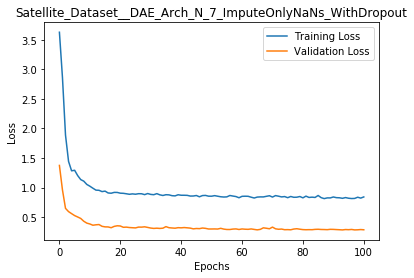

In [23]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [23]:
# '''Remove folder before training again'''
# import shutil
# shutil.rmtree(model_name)

Learning Rate annealing:- Maybe need a smaller learning rate after a while? 
Nesterov momentum:- Check paper to see if all the features have been implemented exactly (like Nesterov?)
              
Experiments to try:
1. Plot different values for different architectures.
2. Try feeding in with just the imputed values instead of the whole predicted data.
3. Try without dropout.

Features needed:

1. Printing out the denormalized data in prediction - DONE
2. Store the ids of NaNs before filling them up with placeholders - Not Needed, wrote a better TEST FUNCTION
3. Do 70/30 Split before training, testing - DONE
4. Add provision in model for changing theta params - DONE
5. Add provision for removing dropout - DONE
6. Plotting Loss function - DONE

In [ ]:
# Saving model

#torch.save(optimizer.state_dict(), filename)
#optimizer.load_state_dict(torch.load(filename))

# Modelling Loading from saved point

# model =  Modelling.DenoisingAutoEncoder(len(trainset.variables()))
# model.load_state_dict(torch.load("./artifacts/saved_model_epoch50"))
# model.eval()

In [ ]:
#Tweaking the learning rate to improve convergence speed
# optimizer = Adam(net.parameters(), LR)

# 4. Testing

In [27]:
net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

tensor([0.3864, 0.4582, 0.6332, 0.5017, 0.2818, 0.4106, 0.5854, 0.5100, 0.2716,
        0.4947, 0.5971, 0.5456, 0.3929, 0.4913, 0.6394, 0.5632, 0.3411, 0.4356,
        0.6208, 0.5817, 0.2811, 0.3883, 0.6361, 0.6025, 0.3089, 0.4286, 0.5985,
        0.5388, 0.3970, 0.4954, 0.6152, 0.5291, 0.3817, 0.4008, 0.6167, 0.5108])
tensor([0.4589, 0.5183, 0.7711, 0.4263, 0.0645, 0.0990, 0.5013, 0.4210, 0.1562,
        0.5636, 0.6463, 0.6098, 0.4722, 0.5470, 0.5445, 0.7797, 0.4530, 0.0700,
        0.5259, 0.7679, 0.1562, 0.0874, 0.7640, 0.7920, 0.1250, 0.0680, 0.5273,
        0.7679, 0.4741, 0.5649, 0.5577, 0.4325, 0.4702, 0.0693, 0.7684, 0.4310])


In [28]:
net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

          0          1           2          3          4          5   \
0  64.731148  77.400238  108.552353  91.698929  57.471291  68.475235   

           6          7          8          9   ...          26         27  \
0  106.244247  93.155312  57.383873  76.467598  ...  105.678589  99.344681   

          28         29          30         31         32         33  \
0  64.218803  76.536942  104.748581  95.134735  63.282013  67.484726   

          34         35  
0  108.58429  92.850616  

[1 rows x 36 columns]
          0          1      2          3     4     5          6          7   \
0  69.368912  84.012482  120.0  82.878372  44.0  37.0  99.606125  82.834877   

     8          9   ...         26     27         28         29         30  \
0  50.0  83.355209  ...  99.766815  125.0  68.922272  83.492554  99.633514   

          31         32    33     34         35  
0  83.060013  68.679825  34.0  123.0  82.871933  

[1 rows x 36 columns]


In [29]:
import pandas as pd
import torch
def test_model(net=None, test_df= None, trainset=None, device =None, logger_level=20):
    """
    Function to evaluate the model on test set
    Should meet the following requirements:
        :-trainset - should be an object of class DataSetForImputation
        :-test_df - should be a Pandas dataframe with NaNs (if there are no NaNs, the same will be returned)
        :-net - should be an object of DenoisingAutoEncoder
    """
    assert isinstance(net, Modelling.DenoisingAutoEncoder)
    assert isinstance(test_df, pd.DataFrame)
    assert isinstance(trainset, dataset_module.DataSetForImputation)
    
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)
    
    NaN_test_df = test_df.reset_index(drop=True)  #Dropping index so that everything is reindexed from 0
       
    test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0)
    test_df_norm = (test_df- trainset.min_df)/(trainset.max_df-trainset.min_df)
    test_df_tensor = torch.tensor(test_df_norm.values).to(device)
        
    net = net.eval()
    logging.debug(f"{test_df_tensor.shape}")
    pred = net(test_df_tensor)
     
    pred =  trainset.get_denormalized_data(pred)  #Predicted dataframe from the mode    
    
    # Replace the NaNs in the original test_df with newly imputed values
    final_pred = NaN_test_df.where(~NaN_test_df.isna(), other = pred)
    logging.debug(f"final_pred:\n {final_pred.head()}")
    
    return final_pred

In [30]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,59.00000,58.000000,74,62.000000,59,58,81.000000,71.000000,55,54.00000,...,75.000000,64,52.000000,57.000000,75.000000,68.000000,56.000000,54,82,72.000000
1,67.00000,73.000000,72,57.000000,63,70,72.000000,57.000000,63,70.00000,...,78.000000,61,68.000000,73.000000,78.000000,61.000000,68.000000,77,82,61.000000
2,80.00000,94.000000,102,83.000000,76,89,98.000000,79.000000,68,77.00000,...,100.000000,83,79.000000,91.000000,104.000000,79.000000,75.000000,79,96,79.000000
3,46.00000,43.000000,112,122.000000,49,49,112.000000,118.000000,52,53.00000,...,110.000000,97,47.000000,40.000000,105.000000,122.000000,44.000000,31,114,136.000000
4,72.14415,93.273026,114,83.282898,63,97,101.964737,82.850388,63,92.07132,...,101.802795,85,70.894684,92.371284,102.140717,82.164833,70.856133,91,108,81.255318


In [31]:
full_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59,58,74,62,59,58,81,71,55,54,...,75,64,52,57,75,68,56,54,82,72
1720,67,73,72,57,63,70,72,57,63,70,...,78,61,68,73,78,61,68,77,82,61
43,80,94,102,83,76,89,98,79,68,77,...,100,83,79,91,104,79,75,79,96,79
3823,46,43,112,122,49,49,112,118,52,53,...,110,97,47,40,105,122,44,31,114,136
3576,63,102,114,87,63,97,110,87,63,92,...,108,85,60,99,104,85,64,91,108,88


In [33]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59.0,58.0,74,62.0,59,58,81.0,71.0,55,54.0,...,75.0,64,52.0,57.0,75.0,68.0,56.0,54,82,72.0
1720,67.0,73.0,72,57.0,63,70,72.0,57.0,63,70.0,...,78.0,61,68.0,73.0,78.0,61.0,68.0,77,82,61.0
43,80.0,94.0,102,83.0,76,89,98.0,79.0,68,77.0,...,100.0,83,79.0,91.0,104.0,79.0,75.0,79,96,79.0
3823,46.0,43.0,112,122.0,49,49,112.0,118.0,52,53.0,...,110.0,97,47.0,40.0,105.0,122.0,44.0,31,114,136.0
3576,NaN,NaN,114,NaN,63,97,NaN,NaN,63,NaN,...,NaN,85,NaN,NaN,NaN,NaN,NaN,91,108,NaN


# 5. Plotting Loss Curve

### Model 2 DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout

In [34]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.1)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [35]:
model_name = "Satellite_Dataset__DAE_Arch_N_7_ImputeOnlyNaNs_With10PercentDropout"

In [36]:
train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

Epoch number:9 Loss: 0.8850


Epoch number:19 Loss: 0.6650


Epoch number:29 Loss: 0.6120


Epoch number:39 Loss: 0.5766


Epoch number:49 Loss: 0.5603


Epoch number:59 Loss: 0.5581


Epoch number:69 Loss: 0.5506


Epoch number:79 Loss: 0.5370


Epoch number:89 Loss: 0.5395


Epoch number:99 Loss: 0.5254


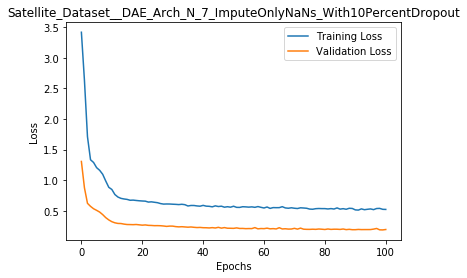

In [37]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [38]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,59.000000,58.000000,74,62.000000,59,58,81.000000,71.000000,55,54.000000,...,75.000000,64,52.000000,57.000000,75.00000,68.000000,56.000000,54,82,72.000000
1,67.000000,73.000000,72,57.000000,63,70,72.000000,57.000000,63,70.000000,...,78.000000,61,68.000000,73.000000,78.00000,61.000000,68.000000,77,82,61.000000
2,80.000000,94.000000,102,83.000000,76,89,98.000000,79.000000,68,77.000000,...,100.000000,83,79.000000,91.000000,104.00000,79.000000,75.000000,79,96,79.000000
3,46.000000,43.000000,112,122.000000,49,49,112.000000,118.000000,52,53.000000,...,110.000000,97,47.000000,40.000000,105.00000,122.000000,44.000000,31,114,136.000000
4,69.558258,93.521759,114,83.828781,63,97,103.588852,84.455307,63,92.765228,...,103.464752,85,69.635956,93.810318,103.33876,83.233276,69.627319,91,108,84.090729


In [39]:
full_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59,58,74,62,59,58,81,71,55,54,...,75,64,52,57,75,68,56,54,82,72
1720,67,73,72,57,63,70,72,57,63,70,...,78,61,68,73,78,61,68,77,82,61
43,80,94,102,83,76,89,98,79,68,77,...,100,83,79,91,104,79,75,79,96,79
3823,46,43,112,122,49,49,112,118,52,53,...,110,97,47,40,105,122,44,31,114,136
3576,63,102,114,87,63,97,110,87,63,92,...,108,85,60,99,104,85,64,91,108,88


### Model 3 DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout

In [57]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.0)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [64]:
model_name = "Satellite_Dataset__DAE_Arch_N_7_ImputeOnlyNaNs_WithNoDropout"

In [65]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 0.6601


Epoch number:19 Loss: 0.5621


Epoch number:29 Loss: 0.4702


Epoch number:39 Loss: 0.3951


Epoch number:49 Loss: 0.3552


Epoch number:59 Loss: 0.3291


Epoch number:69 Loss: 0.3166


Epoch number:79 Loss: 0.2948


Epoch number:89 Loss: 0.2694


Epoch number:99 Loss: 0.2570


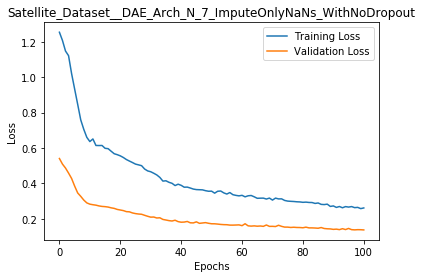

In [66]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [67]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,59.000000,58.00000,74,62.00000,59,58,81.000000,71.000000,55,54.000000,...,75.000000,64,52.0000,57.000000,75.00000,68.000000,56.000000,54,82,72.000000
1,67.000000,73.00000,72,57.00000,63,70,72.000000,57.000000,63,70.000000,...,78.000000,61,68.0000,73.000000,78.00000,61.000000,68.000000,77,82,61.000000
2,80.000000,94.00000,102,83.00000,76,89,98.000000,79.000000,68,77.000000,...,100.000000,83,79.0000,91.000000,104.00000,79.000000,75.000000,79,96,79.000000
3,46.000000,43.00000,112,122.00000,49,49,112.000000,118.000000,52,53.000000,...,110.000000,97,47.0000,40.000000,105.00000,122.000000,44.000000,31,114,136.000000
4,68.440773,91.31942,114,81.93959,63,97,101.175217,82.865517,63,85.992416,...,100.722015,85,67.4916,90.686966,99.79615,81.202774,66.791473,91,108,81.254547


In [68]:
full_test_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59,58,74,62,59,58,81,71,55,54,...,75,64,52,57,75,68,56,54,82,72
1720,67,73,72,57,63,70,72,57,63,70,...,78,61,68,73,78,61,68,77,82,61
43,80,94,102,83,76,89,98,79,68,77,...,100,83,79,91,104,79,75,79,96,79
3823,46,43,112,122,49,49,112,118,52,53,...,110,97,47,40,105,122,44,31,114,136
3576,63,102,114,87,63,97,110,87,63,92,...,108,85,60,99,104,85,64,91,108,88


In [69]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59.0,58.0,74,62.0,59,58,81.0,71.0,55,54.0,...,75.0,64,52.0,57.0,75.0,68.0,56.0,54,82,72.0
1720,67.0,73.0,72,57.0,63,70,72.0,57.0,63,70.0,...,78.0,61,68.0,73.0,78.0,61.0,68.0,77,82,61.0
43,80.0,94.0,102,83.0,76,89,98.0,79.0,68,77.0,...,100.0,83,79.0,91.0,104.0,79.0,75.0,79,96,79.0
3823,46.0,43.0,112,122.0,49,49,112.0,118.0,52,53.0,...,110.0,97,47.0,40.0,105.0,122.0,44.0,31,114,136.0
3576,NaN,NaN,114,NaN,63,97,NaN,NaN,63,NaN,...,NaN,85,NaN,NaN,NaN,NaN,NaN,91,108,NaN


### Model 4 DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout

In [70]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 3, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [71]:
model_name = "Satellite_Dataset__DAE_Arch_N_3_ImputeOnlyNaNs_WithDropout"

In [72]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 1.1289


Epoch number:19 Loss: 0.9126


Epoch number:29 Loss: 0.8822


Epoch number:39 Loss: 0.8730


Epoch number:49 Loss: 0.8510


Epoch number:59 Loss: 0.8408


Epoch number:69 Loss: 0.8381


Epoch number:79 Loss: 0.8623


Epoch number:89 Loss: 0.8467


Epoch number:99 Loss: 0.8184


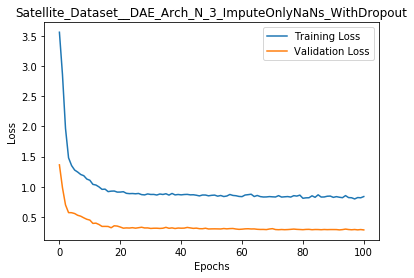

In [73]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [74]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,59.0000,58.000000,74,62.000000,59,58,81.000000,71.000000,55,54.000000,...,75.000000,64,52.000000,57.000000,75.000000,68.000000,56.000000,54,82,72.00000
1,67.0000,73.000000,72,57.000000,63,70,72.000000,57.000000,63,70.000000,...,78.000000,61,68.000000,73.000000,78.000000,61.000000,68.000000,77,82,61.00000
2,80.0000,94.000000,102,83.000000,76,89,98.000000,79.000000,68,77.000000,...,100.000000,83,79.000000,91.000000,104.000000,79.000000,75.000000,79,96,79.00000
3,46.0000,43.000000,112,122.000000,49,49,112.000000,118.000000,52,53.000000,...,110.000000,97,47.000000,40.000000,105.000000,122.000000,44.000000,31,114,136.00000
4,71.9095,91.514091,114,81.937958,63,97,101.145172,82.227814,63,90.682938,...,100.877197,85,70.968948,90.907257,101.910339,81.957016,70.667992,91,108,82.45845


In [75]:
full_test_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59,58,74,62,59,58,81,71,55,54,...,75,64,52,57,75,68,56,54,82,72
1720,67,73,72,57,63,70,72,57,63,70,...,78,61,68,73,78,61,68,77,82,61
43,80,94,102,83,76,89,98,79,68,77,...,100,83,79,91,104,79,75,79,96,79
3823,46,43,112,122,49,49,112,118,52,53,...,110,97,47,40,105,122,44,31,114,136
3576,63,102,114,87,63,97,110,87,63,92,...,108,85,60,99,104,85,64,91,108,88


In [77]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59.0,58.0,74,62.0,59,58,81.0,71.0,55,54.0,...,75.0,64,52.0,57.0,75.0,68.0,56.0,54,82,72.0
1720,67.0,73.0,72,57.0,63,70,72.0,57.0,63,70.0,...,78.0,61,68.0,73.0,78.0,61.0,68.0,77,82,61.0
43,80.0,94.0,102,83.0,76,89,98.0,79.0,68,77.0,...,100.0,83,79.0,91.0,104.0,79.0,75.0,79,96,79.0
3823,46.0,43.0,112,122.0,49,49,112.0,118.0,52,53.0,...,110.0,97,47.0,40.0,105.0,122.0,44.0,31,114,136.0
3576,NaN,NaN,114,NaN,63,97,NaN,NaN,63,NaN,...,NaN,85,NaN,NaN,NaN,NaN,NaN,91,108,NaN


### Model 5 DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout

In [78]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 3, input_dropout=0.1)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [79]:
model_name = "Satellite_Dataset__DAE_Arch_N_3_ImputeOnlyNaNs_With10PercentDropout"


In [80]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 0.9412


Epoch number:19 Loss: 0.6668


Epoch number:29 Loss: 0.6328


Epoch number:39 Loss: 0.5876


Epoch number:49 Loss: 0.5989


Epoch number:59 Loss: 0.5692


Epoch number:69 Loss: 0.5602


Epoch number:79 Loss: 0.5433


Epoch number:89 Loss: 0.5330


Epoch number:99 Loss: 0.5247


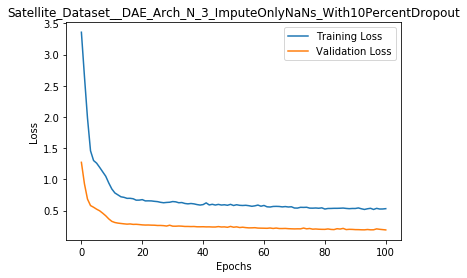

In [83]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")

In [84]:
test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,59.000000,58.000000,74,62.000000,59,58,81.000000,71.00000,55,54.000000,...,75.00000,64,52.000000,57.000000,75.000000,68.000000,56.000000,54,82,72.000000
1,67.000000,73.000000,72,57.000000,63,70,72.000000,57.00000,63,70.000000,...,78.00000,61,68.000000,73.000000,78.000000,61.000000,68.000000,77,82,61.000000
2,80.000000,94.000000,102,83.000000,76,89,98.000000,79.00000,68,77.000000,...,100.00000,83,79.000000,91.000000,104.000000,79.000000,75.000000,79,96,79.000000
3,46.000000,43.000000,112,122.000000,49,49,112.000000,118.00000,52,53.000000,...,110.00000,97,47.000000,40.000000,105.000000,122.000000,44.000000,31,114,136.000000
4,68.942261,92.122864,114,82.677574,63,97,102.892624,82.97319,63,92.310097,...,102.52327,85,68.542686,92.225426,102.573853,83.228287,68.713531,91,108,83.844955


In [85]:
full_test_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59,58,74,62,59,58,81,71,55,54,...,75,64,52,57,75,68,56,54,82,72
1720,67,73,72,57,63,70,72,57,63,70,...,78,61,68,73,78,61,68,77,82,61
43,80,94,102,83,76,89,98,79,68,77,...,100,83,79,91,104,79,75,79,96,79
3823,46,43,112,122,49,49,112,118,52,53,...,110,97,47,40,105,122,44,31,114,136
3576,63,102,114,87,63,97,110,87,63,92,...,108,85,60,99,104,85,64,91,108,88


In [86]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2514,59.0,58.0,74,62.0,59,58,81.0,71.0,55,54.0,...,75.0,64,52.0,57.0,75.0,68.0,56.0,54,82,72.0
1720,67.0,73.0,72,57.0,63,70,72.0,57.0,63,70.0,...,78.0,61,68.0,73.0,78.0,61.0,68.0,77,82,61.0
43,80.0,94.0,102,83.0,76,89,98.0,79.0,68,77.0,...,100.0,83,79.0,91.0,104.0,79.0,75.0,79,96,79.0
3823,46.0,43.0,112,122.0,49,49,112.0,118.0,52,53.0,...,110.0,97,47.0,40.0,105.0,122.0,44.0,31,114,136.0
3576,NaN,NaN,114,NaN,63,97,NaN,NaN,63,NaN,...,NaN,85,NaN,NaN,NaN,NaN,NaN,91,108,NaN


### Model 7 DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout

In [87]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 9, input_dropout=0.0)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
testset = dataset_module.DataSetForImputation(test_df, normalize=True)

train_loader = td.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True, **kwargs)
val_loader  = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

In [88]:
model_name = "Satellite_Dataset__DAE_Arch_N_9_ImputeOnlyNaNs_WithNoDropout"

In [89]:
train_model(0,101, net, model_name)

Epoch number:9 Loss: 0.7286


Epoch number:19 Loss: 0.5854


Epoch number:29 Loss: 0.5111


Epoch number:39 Loss: 0.4127


Epoch number:49 Loss: 0.3624


Epoch number:59 Loss: 0.3209


Epoch number:69 Loss: 0.2866


Epoch number:79 Loss: 0.2636


Epoch number:89 Loss: 0.2543


Epoch number:99 Loss: 0.2405


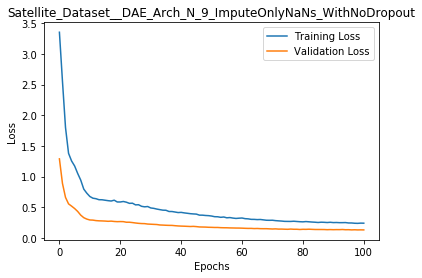

In [90]:
utils.plot_train_and_val_loss_curves(filename1= f"{model_name}/artifacts/loss_curve",
                                     filename2= f"{model_name}/artifacts/val_loss_curve",
                                     title=f"{model_name}")